# Picarro incubation, data analyzed 9/20/17
## Script written by Silene DeCiucies
### Edited by Thea Whitman


In [1]:
library(data.table)
library(ggplot2)
library(cowplot)
library(dplyr)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#############################################################################################################
#  Define constants
#############################################################################################################

jar.headspace.volume <- 0.867
co2.density_30C <- 0.001778
co2.carbon.frac <- 12.01 / 44.0095


In [3]:
# Just checking how they calculated their d13C ratios...
PDBratio = 0.0112372
C12 = 4.108773
C13 = 0.1432768
d13Creported = 2103.170
C1213ratio = C13/C12
C1213ratio
d13Ccalculated = (C1213ratio/PDBratio -1 )*1000
d13Ccalculated
# Confirms the C12 is only 12, for Ctot we need to add 13C.

[1] 0.03487095

[1] 2103.17

In [4]:
#############################################################################################################
#  Load Data Files 
#############################################################################################################
load("../data/Picarro_Data/samplesonly9_2.Rda")
pic.data <- data.table(samplesonly9_2) # Picarro data
frac6  <- fread("../data/Picarro_Data/frac_Thea.txt") # List of fractions (of sampling volume?) for each Mason jar
carbon  <- fread("../data/Picarro_Data/carbon_table2_thea.txt") # List of total C in samples
mass5  <- fread("../data/Picarro_Data/thea_mass2.txt") # List of total soil mass in each Quorpak
#For the first set of data Silene used carbon_table_thea and thea_mass (this was before the destructive sampling)

In [5]:
SampleData = data.table(read.csv("../data/Picarro_Data/NEON_for_Picarro.csv"))
SampleData = SampleData %>%
    filter(Day==26)
SampleData = data.table(SampleData)

In [6]:
#############################################################################################################
#  Data Preprocessing  
#############################################################################################################
drop.cols <- c("EPOCH_TIME", "DATE", "TIME", "FRAC_HRS_SINCE_JAN1", 
               "ALARM_STATUS", "INST_STATUS", "CavityTemp", "CavityPressure", "OutletValve", 
               "HP_12CH4_dry", "HP_Delta_iCH4_Raw", "HR_12CH4_dry", "HR_Delta_iCH4_Raw", "H2O",
               "command",  "sample", "sample.timepoint",  "rep",  "purge")  #List of unwanted columns

pic.data[, drop.cols := NULL, with=F]   # drop columns we don't need from Picarro data
#blanks <- c(1,2,63,64)  #identify blanks in the run (sample.test IDs)
#pic.data <- pic.data[!(sample.test %in% blanks)]  # drop rows for empty sample jars (blanks)
pic.data[, sample.rep := as.integer(sample.rep)] # establishes sample.rep as integer

pic.data[step=="purge", sample.rep := sample.rep + 1L]
    # Find only the steps where it was purging.
    # Then, match purge data with analysis data that follows (rather than precedes) it

pic.data[, samprep := factor(paste(formatC(sample.test, digits = 4, flag="0"), formatC(sample.rep, digits = 4, flag="0"), sep=","))]
    # Designates the samprep column that says which analysis steps are related
    # Also adds 0's to make them all the same number of digits.

pic.data[, samprepstep := factor(paste(samprep, formatC(step), sep=","))]
    # Adding a column with the jar, timepoint, and step factor.

pic.data[, CO2tot := X12CO2_dry + X13CO2, keyby=samprep]
  # Need to add the 12CO2 and the 13CO2 to get total CO2.

pic.data[, maxco2 := max(CO2tot, na.rm = T), keyby=samprep]
  # Use maximum CO2 concentration measured as representative of CO2 in the headspace
  # May want to sum 13CO2 and 12CO2 since label so high
  # Note warning may say there are no NAs.



Warning message in `[.data.table`(pic.data, , `:=`(drop.cols, NULL), with = F):
“with=FALSE together with := was deprecated in v1.9.4 released Oct 2014. Please wrap the LHS of := with parentheses; e.g., DT[,(myVar):=sum(b),by=a] to assign to column name(s) held in variable myVar. See ?':=' for other examples. As warned in 2014, this is now a warning.”

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2    Delta_Raw_iCO2 sample.test
1            NA                   NA          NA       NA        1         
2            NA                   NA          NA       NA        1         
3            NA                   NA          NA       NA       64         
4      248.7937             2.283415   0.1149904 3481.450       64         
5      248.7937             2.283415   0.1149904 3481.450       64         
6      248.7937             2.283415   0.1149904 3481.450       64         
7      248.7937             2.202543   0.1109177 3481.450       64         
8      248.7937             2.202543   0.1094418 3421.816       64         
9      248.7938             2.202543   0.1094418 3421.816       64         
10     248.7938             2.202543   0.1094418 3421.816       64         
11     248.7938             2.316327   0.1150956 3421.816       64         
12     248.7938             2.316327   0.1109632 3263.054       64         
13     248.7938             2.316327   0.1109632 3263.054       64         
14     248.7938             2.316327   0.1109632 3263.054       64         
15     248.7938             2.361844   0.1131436 3263.054       64         
16     248.7938             2.361844   0.1098121 3137.528       64         
17     248.7938             2.361844   0.1098121 3137.528       64         
18     248.7939             2.361844   0.1098121 3137.528       64         
19     248.7939             2.169762   0.1008814 3137.528       64         
20     248.7939             2.169762   0.1088741 3465.338       64         
21     248.7939             2.169762   0.1088741 3465.338       64         
22     248.7939             2.169762   0.1088741 3465.338       64         
23     248.7939             2.223415   0.1115663 3465.338       64         
24     248.7939             2.223415   0.1112694 3453.455       64         
25     248.7939             2.223415   0.1112694 3453.455       64         
26     248.7939             2.223415   0.1112694 3453.455       64         
27     248.7939             2.290798   0.1146415 3453.455       64         
28     248.7940             2.290798   0.1107431 3302.014       64         
29     248.7940             2.290798   0.1107431 3302.014       64         
30     248.7940             2.290798   0.1107431 3302.014       64         
⋮      ⋮                    ⋮          ⋮         ⋮              ⋮          
700739 265.6545             6.862336   0.1670462 1166.239       63         
700740 265.6545             6.862336   0.1670462 1166.239       63         
700741 265.6545             7.182577   0.1748416 1166.239       63         
700742 265.6545             7.182577   0.1669714 1068.730       63         
700743 265.6545             7.182577   0.1669714 1068.730       63         
700744 265.6545             7.182577   0.1669714 1068.730       63         
700745 265.6545             7.121419   0.1655497 1068.730       63         
700746 265.6545             7.121419   0.1729925 1161.736       63         
700747 265.6546             7.121419   0.1729925 1161.736       63         
700748 265.6546             7.121419   0.1729925 1161.736       63         
700749 265.6546             7.115940   0.1728594 1161.736       63         
700750 265.6546             7.115940   0.1751032 1189.796       63         
700751 265.6546             7.115940   0.1751032 1189.796       63         
700752 265.6546             7.115940   0.1751032 1189.796       63         
700753 265.6546             7.204051   0.1772713 1189.796       63         
700754 265.6546             7.204051   0.1708336 1110.272       63         
700755 265.6546             7.204051   0.1708336 1110.272       63         
700756 265.6546             7.204051   0.1708336 1110.272       63         
700757 265.6547             7.199510   0.1707260 1110.272       63         
700758 265.6547             7.199510   0.1687459 1085.798       63         
700759 265.6547             7.199510   0.1687459 1085.7

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2    Delta_Raw_iCO2 sample.test
1            NA                   NA          NA       NA        1         
2            NA                   NA          NA       NA        1         
3            NA                   NA          NA       NA       64         
4      248.7937             2.283415   0.1149904 3481.450       64         
5      248.7937             2.283415   0.1149904 3481.450       64         
6      248.7937             2.283415   0.1149904 3481.450       64         
7      248.7937             2.202543   0.1109177 3481.450       64         
8      248.7937             2.202543   0.1094418 3421.816       64         
9      248.7938             2.202543   0.1094418 3421.816       64         
10     248.7938             2.202543   0.1094418 3421.816       64         
11     248.7938             2.316327   0.1150956 3421.816       64         
12     248.7938             2.316327   0.1109632 3263.054       64         
13     248.7938             2.316327   0.1109632 3263.054       64         
14     248.7938             2.316327   0.1109632 3263.054       64         
15     248.7938             2.361844   0.1131436 3263.054       64         
16     248.7938             2.361844   0.1098121 3137.528       64         
17     248.7938             2.361844   0.1098121 3137.528       64         
18     248.7939             2.361844   0.1098121 3137.528       64         
19     248.7939             2.169762   0.1008814 3137.528       64         
20     248.7939             2.169762   0.1088741 3465.338       64         
21     248.7939             2.169762   0.1088741 3465.338       64         
22     248.7939             2.169762   0.1088741 3465.338       64         
23     248.7939             2.223415   0.1115663 3465.338       64         
24     248.7939             2.223415   0.1112694 3453.455       64         
25     248.7939             2.223415   0.1112694 3453.455       64         
26     248.7939             2.223415   0.1112694 3453.455       64         
27     248.7939             2.290798   0.1146415 3453.455       64         
28     248.7940             2.290798   0.1107431 3302.014       64         
29     248.7940             2.290798   0.1107431 3302.014       64         
30     248.7940             2.290798   0.1107431 3302.014       64         
⋮      ⋮                    ⋮          ⋮         ⋮              ⋮          
700739 265.6545             6.862336   0.1670462 1166.239       63         
700740 265.6545             6.862336   0.1670462 1166.239       63         
700741 265.6545             7.182577   0.1748416 1166.239       63         
700742 265.6545             7.182577   0.1669714 1068.730       63         
700743 265.6545             7.182577   0.1669714 1068.730       63         
700744 265.6545             7.182577   0.1669714 1068.730       63         
700745 265.6545             7.121419   0.1655497 1068.730       63         
700746 265.6545             7.121419   0.1729925 1161.736       63         
700747 265.6546             7.121419   0.1729925 1161.736       63         
700748 265.6546             7.121419   0.1729925 1161.736       63         
700749 265.6546             7.115940   0.1728594 1161.736       63         
700750 265.6546             7.115940   0.1751032 1189.796       63         
700751 265.6546             7.115940   0.1751032 1189.796       63         
700752 265.6546             7.115940   0.1751032 1189.796       63         
700753 265.6546             7.204051   0.1772713 1189.796       63         
700754 265.6546             7.204051   0.1708336 1110.272       63         
700755 265.6546             7.204051   0.1708336 1110.272       63         
700756 265.6546             7.204051   0.1708336 1110.272       63         
700757 265.6547             7.199510   0.1707260 1110.272       63         
700758 265.6547             7.199510   0.1687459 1085.798       63         
700759 265.6547             7.199510   0.1687459 1085.7

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2    Delta_Raw_iCO2 sample.test
1            NA                   NA          NA       NA        1         
2            NA                   NA          NA       NA        1         
3            NA                   NA          NA       NA       64         
4      248.7937             2.283415   0.1149904 3481.450       64         
5      248.7937             2.283415   0.1149904 3481.450       64         
6      248.7937             2.283415   0.1149904 3481.450       64         
7      248.7937             2.202543   0.1109177 3481.450       64         
8      248.7937             2.202543   0.1094418 3421.816       64         
9      248.7938             2.202543   0.1094418 3421.816       64         
10     248.7938             2.202543   0.1094418 3421.816       64         
11     248.7938             2.316327   0.1150956 3421.816       64         
12     248.7938             2.316327   0.1109632 3263.054       64         
13     248.7938             2.316327   0.1109632 3263.054       64         
14     248.7938             2.316327   0.1109632 3263.054       64         
15     248.7938             2.361844   0.1131436 3263.054       64         
16     248.7938             2.361844   0.1098121 3137.528       64         
17     248.7938             2.361844   0.1098121 3137.528       64         
18     248.7939             2.361844   0.1098121 3137.528       64         
19     248.7939             2.169762   0.1008814 3137.528       64         
20     248.7939             2.169762   0.1088741 3465.338       64         
21     248.7939             2.169762   0.1088741 3465.338       64         
22     248.7939             2.169762   0.1088741 3465.338       64         
23     248.7939             2.223415   0.1115663 3465.338       64         
24     248.7939             2.223415   0.1112694 3453.455       64         
25     248.7939             2.223415   0.1112694 3453.455       64         
26     248.7939             2.223415   0.1112694 3453.455       64         
27     248.7939             2.290798   0.1146415 3453.455       64         
28     248.7940             2.290798   0.1107431 3302.014       64         
29     248.7940             2.290798   0.1107431 3302.014       64         
30     248.7940             2.290798   0.1107431 3302.014       64         
⋮      ⋮                    ⋮          ⋮         ⋮              ⋮          
700739 265.6545             6.862336   0.1670462 1166.239       63         
700740 265.6545             6.862336   0.1670462 1166.239       63         
700741 265.6545             7.182577   0.1748416 1166.239       63         
700742 265.6545             7.182577   0.1669714 1068.730       63         
700743 265.6545             7.182577   0.1669714 1068.730       63         
700744 265.6545             7.182577   0.1669714 1068.730       63         
700745 265.6545             7.121419   0.1655497 1068.730       63         
700746 265.6545             7.121419   0.1729925 1161.736       63         
700747 265.6546             7.121419   0.1729925 1161.736       63         
700748 265.6546             7.121419   0.1729925 1161.736       63         
700749 265.6546             7.115940   0.1728594 1161.736       63         
700750 265.6546             7.115940   0.1751032 1189.796       63         
700751 265.6546             7.115940   0.1751032 1189.796       63         
700752 265.6546             7.115940   0.1751032 1189.796       63         
700753 265.6546             7.204051   0.1772713 1189.796       63         
700754 265.6546             7.204051   0.1708336 1110.272       63         
700755 265.6546             7.204051   0.1708336 1110.272       63         
700756 265.6546             7.204051   0.1708336 1110.272       63         
700757 265.6547             7.199510   0.1707260 1110.272       63         
700758 265.6547             7.199510   0.1687459 1085.798       63         
700759 265.6547             7.199510   0.1687459 1085.7

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2    Delta_Raw_iCO2 sample.test
1            NA                   NA          NA       NA        1         
2            NA                   NA          NA       NA        1         
3            NA                   NA          NA       NA       64         
4      248.7937             2.283415   0.1149904 3481.450       64         
5      248.7937             2.283415   0.1149904 3481.450       64         
6      248.7937             2.283415   0.1149904 3481.450       64         
7      248.7937             2.202543   0.1109177 3481.450       64         
8      248.7937             2.202543   0.1094418 3421.816       64         
9      248.7938             2.202543   0.1094418 3421.816       64         
10     248.7938             2.202543   0.1094418 3421.816       64         
11     248.7938             2.316327   0.1150956 3421.816       64         
12     248.7938             2.316327   0.1109632 3263.054       64         
13     248.7938             2.316327   0.1109632 3263.054       64         
14     248.7938             2.316327   0.1109632 3263.054       64         
15     248.7938             2.361844   0.1131436 3263.054       64         
16     248.7938             2.361844   0.1098121 3137.528       64         
17     248.7938             2.361844   0.1098121 3137.528       64         
18     248.7939             2.361844   0.1098121 3137.528       64         
19     248.7939             2.169762   0.1008814 3137.528       64         
20     248.7939             2.169762   0.1088741 3465.338       64         
21     248.7939             2.169762   0.1088741 3465.338       64         
22     248.7939             2.169762   0.1088741 3465.338       64         
23     248.7939             2.223415   0.1115663 3465.338       64         
24     248.7939             2.223415   0.1112694 3453.455       64         
25     248.7939             2.223415   0.1112694 3453.455       64         
26     248.7939             2.223415   0.1112694 3453.455       64         
27     248.7939             2.290798   0.1146415 3453.455       64         
28     248.7940             2.290798   0.1107431 3302.014       64         
29     248.7940             2.290798   0.1107431 3302.014       64         
30     248.7940             2.290798   0.1107431 3302.014       64         
⋮      ⋮                    ⋮          ⋮         ⋮              ⋮          
700739 265.6545             6.862336   0.1670462 1166.239       63         
700740 265.6545             6.862336   0.1670462 1166.239       63         
700741 265.6545             7.182577   0.1748416 1166.239       63         
700742 265.6545             7.182577   0.1669714 1068.730       63         
700743 265.6545             7.182577   0.1669714 1068.730       63         
700744 265.6545             7.182577   0.1669714 1068.730       63         
700745 265.6545             7.121419   0.1655497 1068.730       63         
700746 265.6545             7.121419   0.1729925 1161.736       63         
700747 265.6546             7.121419   0.1729925 1161.736       63         
700748 265.6546             7.121419   0.1729925 1161.736       63         
700749 265.6546             7.115940   0.1728594 1161.736       63         
700750 265.6546             7.115940   0.1751032 1189.796       63         
700751 265.6546             7.115940   0.1751032 1189.796       63         
700752 265.6546             7.115940   0.1751032 1189.796       63         
700753 265.6546             7.204051   0.1772713 1189.796       63         
700754 265.6546             7.204051   0.1708336 1110.272       63         
700755 265.6546             7.204051   0.1708336 1110.272       63         
700756 265.6546             7.204051   0.1708336 1110.272       63         
700757 265.6547             7.199510   0.1707260 1110.272       63         
700758 265.6547             7.199510   0.1687459 1085.798       63         
700759 265.6547             7.199510   0.1687459 1085.7

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2    Delta_Raw_iCO2 sample.test
1            NA                   NA          NA       NA        1         
2            NA                   NA          NA       NA        1         
3            NA                   NA          NA       NA       64         
4      248.7937             2.283415   0.1149904 3481.450       64         
5      248.7937             2.283415   0.1149904 3481.450       64         
6      248.7937             2.283415   0.1149904 3481.450       64         
7      248.7937             2.202543   0.1109177 3481.450       64         
8      248.7937             2.202543   0.1094418 3421.816       64         
9      248.7938             2.202543   0.1094418 3421.816       64         
10     248.7938             2.202543   0.1094418 3421.816       64         
11     248.7938             2.316327   0.1150956 3421.816       64         
12     248.7938             2.316327   0.1109632 3263.054       64         
13     248.7938             2.316327   0.1109632 3263.054       64         
14     248.7938             2.316327   0.1109632 3263.054       64         
15     248.7938             2.361844   0.1131436 3263.054       64         
16     248.7938             2.361844   0.1098121 3137.528       64         
17     248.7938             2.361844   0.1098121 3137.528       64         
18     248.7939             2.361844   0.1098121 3137.528       64         
19     248.7939             2.169762   0.1008814 3137.528       64         
20     248.7939             2.169762   0.1088741 3465.338       64         
21     248.7939             2.169762   0.1088741 3465.338       64         
22     248.7939             2.169762   0.1088741 3465.338       64         
23     248.7939             2.223415   0.1115663 3465.338       64         
24     248.7939             2.223415   0.1112694 3453.455       64         
25     248.7939             2.223415   0.1112694 3453.455       64         
26     248.7939             2.223415   0.1112694 3453.455       64         
27     248.7939             2.290798   0.1146415 3453.455       64         
28     248.7940             2.290798   0.1107431 3302.014       64         
29     248.7940             2.290798   0.1107431 3302.014       64         
30     248.7940             2.290798   0.1107431 3302.014       64         
⋮      ⋮                    ⋮          ⋮         ⋮              ⋮          
700739 265.6545             6.862336   0.1670462 1166.239       63         
700740 265.6545             6.862336   0.1670462 1166.239       63         
700741 265.6545             7.182577   0.1748416 1166.239       63         
700742 265.6545             7.182577   0.1669714 1068.730       63         
700743 265.6545             7.182577   0.1669714 1068.730       63         
700744 265.6545             7.182577   0.1669714 1068.730       63         
700745 265.6545             7.121419   0.1655497 1068.730       63         
700746 265.6545             7.121419   0.1729925 1161.736       63         
700747 265.6546             7.121419   0.1729925 1161.736       63         
700748 265.6546             7.121419   0.1729925 1161.736       63         
700749 265.6546             7.115940   0.1728594 1161.736       63         
700750 265.6546             7.115940   0.1751032 1189.796       63         
700751 265.6546             7.115940   0.1751032 1189.796       63         
700752 265.6546             7.115940   0.1751032 1189.796       63         
700753 265.6546             7.204051   0.1772713 1189.796       63         
700754 265.6546             7.204051   0.1708336 1110.272       63         
700755 265.6546             7.204051   0.1708336 1110.272       63         
700756 265.6546             7.204051   0.1708336 1110.272       63         
700757 265.6547             7.199510   0.1707260 1110.272       63         
700758 265.6547             7.199510   0.1687459 1085.798       63         
700759 265.6547             7.199510   0.1687459 1085.7

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2     Delta_Raw_iCO2 sample.test
1            NA                    NA          NA       NA       1          
2            NA                    NA          NA       NA       1          
3            NA                    NA          NA       NA       1          
4      248.8083             1.1069290  0.03379633 1717.012       1          
5      248.8083             1.1069290  0.02631529 1115.584       1          
6      248.8084             1.1069290  0.02631529 1115.584       1          
7      248.8084             1.1069290  0.02631529 1115.584       1          
8      248.8084             1.0898676  0.02590969 1115.584       1          
9      248.8084             1.0898676  0.02512090 1051.178       1          
10     248.8084             1.0898676  0.02512090 1051.178       1          
11     248.8084             1.0898676  0.02512090 1051.178       1          
12     248.8084             1.1071249  0.02551867 1051.178       1          
13     248.8084             1.1071249  0.02754645 1214.169       1          
14     248.8084             1.1071249  0.02754645 1214.169       1          
15     248.8085             1.1071249  0.02754645 1214.169       1          
16     248.8085             0.9769975  0.02430874 1214.169       1          
17     248.8085             0.9769975  0.03959448 2606.476       1          
18     248.8085             0.9769975  0.03959448 2606.476       1          
19     248.8085             0.9769975  0.03959448 2606.476       1          
20     248.8085             1.0804166  0.04378572 2606.476       1          
21     248.8085             1.0804166  0.02573581 1119.769       1          
22     248.8085             1.0804166  0.02573581 1119.769       1          
23     248.8085             1.0804166  0.02573581 1119.769       1          
24     248.8085             1.0203000  0.02430382 1119.769       1          
25     248.8085             1.0203000  0.03083495 1689.411       1          
26     248.8086             1.0203000  0.03083495 1689.411       1          
27     248.8086             1.0203000  0.03083495 1689.411       1          
28     248.8086             1.0246390  0.03096608 1689.411       1          
29     248.8086             1.0246390  0.02737178 1377.246       1          
30     248.8086             1.0246390  0.02737178 1377.246       1          
⋮      ⋮                    ⋮          ⋮          ⋮              ⋮          
700739 264.7327             3.916573   0.1449422  2293.295       64         
700740 264.7327             3.973299   0.1470415  2293.295       64         
700741 264.7327             3.973299   0.1381550  2094.262       64         
700742 264.7327             3.973299   0.1381550  2094.262       64         
700743 264.7328             3.973299   0.1381550  2094.262       64         
700744 264.7328             4.074629   0.1416783  2094.262       64         
700745 264.7328             4.074629   0.1501732  2279.791       64         
700746 264.7328             4.074629   0.1501732  2279.791       64         
700747 264.7328             4.074629   0.1501732  2279.791       64         
700748 264.7328             4.108773   0.1514316  2279.791       64         
700749 264.7328             4.108773   0.1432768  2103.170       64         
700750 264.7328             4.108773   0.1432768  2103.170       64         
700751 264.7328             4.108773   0.1432768  2103.170       64         
700752 264.7328             4.144484   0.1445221  2103.170       64         
700753 264.7328             4.144484   0.1459200  2133.186       64         
700754 264.7329             4.144484   0.1459200  2133.186       64         
700755 264.7329             4.144484   0.1459200  2133.186       64         
700756 264.7329             4.100374   0.1443669  2133.186       64         
700757 264.7329             4.100374   0.1602402  2477.683       64         
700758 264.7329             4.100374   0.1602402  2477.683       64         
700

Warning message in max(CO2tot, na.rm = T):
“no non-missing arguments to max; returning -Inf”

FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2     Delta_Raw_iCO2 sample.test
1            NA                    NA          NA       NA       1          
2            NA                    NA          NA       NA       1          
3            NA                    NA          NA       NA       1          
4      248.8083             1.1069290  0.03379633 1717.012       1          
5      248.8083             1.1069290  0.02631529 1115.584       1          
6      248.8084             1.1069290  0.02631529 1115.584       1          
7      248.8084             1.1069290  0.02631529 1115.584       1          
8      248.8084             1.0898676  0.02590969 1115.584       1          
9      248.8084             1.0898676  0.02512090 1051.178       1          
10     248.8084             1.0898676  0.02512090 1051.178       1          
11     248.8084             1.0898676  0.02512090 1051.178       1          
12     248.8084             1.1071249  0.02551867 1051.178       1          
13     248.8084             1.1071249  0.02754645 1214.169       1          
14     248.8084             1.1071249  0.02754645 1214.169       1          
15     248.8085             1.1071249  0.02754645 1214.169       1          
16     248.8085             0.9769975  0.02430874 1214.169       1          
17     248.8085             0.9769975  0.03959448 2606.476       1          
18     248.8085             0.9769975  0.03959448 2606.476       1          
19     248.8085             0.9769975  0.03959448 2606.476       1          
20     248.8085             1.0804166  0.04378572 2606.476       1          
21     248.8085             1.0804166  0.02573581 1119.769       1          
22     248.8085             1.0804166  0.02573581 1119.769       1          
23     248.8085             1.0804166  0.02573581 1119.769       1          
24     248.8085             1.0203000  0.02430382 1119.769       1          
25     248.8085             1.0203000  0.03083495 1689.411       1          
26     248.8086             1.0203000  0.03083495 1689.411       1          
27     248.8086             1.0203000  0.03083495 1689.411       1          
28     248.8086             1.0246390  0.03096608 1689.411       1          
29     248.8086             1.0246390  0.02737178 1377.246       1          
30     248.8086             1.0246390  0.02737178 1377.246       1          
⋮      ⋮                    ⋮          ⋮          ⋮              ⋮          
700739 264.7327             3.916573   0.1449422  2293.295       64         
700740 264.7327             3.973299   0.1470415  2293.295       64         
700741 264.7327             3.973299   0.1381550  2094.262       64         
700742 264.7327             3.973299   0.1381550  2094.262       64         
700743 264.7328             3.973299   0.1381550  2094.262       64         
700744 264.7328             4.074629   0.1416783  2094.262       64         
700745 264.7328             4.074629   0.1501732  2279.791       64         
700746 264.7328             4.074629   0.1501732  2279.791       64         
700747 264.7328             4.074629   0.1501732  2279.791       64         
700748 264.7328             4.108773   0.1514316  2279.791       64         
700749 264.7328             4.108773   0.1432768  2103.170       64         
700750 264.7328             4.108773   0.1432768  2103.170       64         
700751 264.7328             4.108773   0.1432768  2103.170       64         
700752 264.7328             4.144484   0.1445221  2103.170       64         
700753 264.7328             4.144484   0.1459200  2133.186       64         
700754 264.7329             4.144484   0.1459200  2133.186       64         
700755 264.7329             4.144484   0.1459200  2133.186       64         
700756 264.7329             4.100374   0.1443669  2133.186       64         
700757 264.7329             4.100374   0.1602402  2477.683       64         
700758 264.7329             4.100374   0.1602402  2477.683       64         
700

Warning message:
“Removed 36 rows containing missing values (geom_point).”

Warning message:
“Removed 36 rows containing missing values (geom_point).”

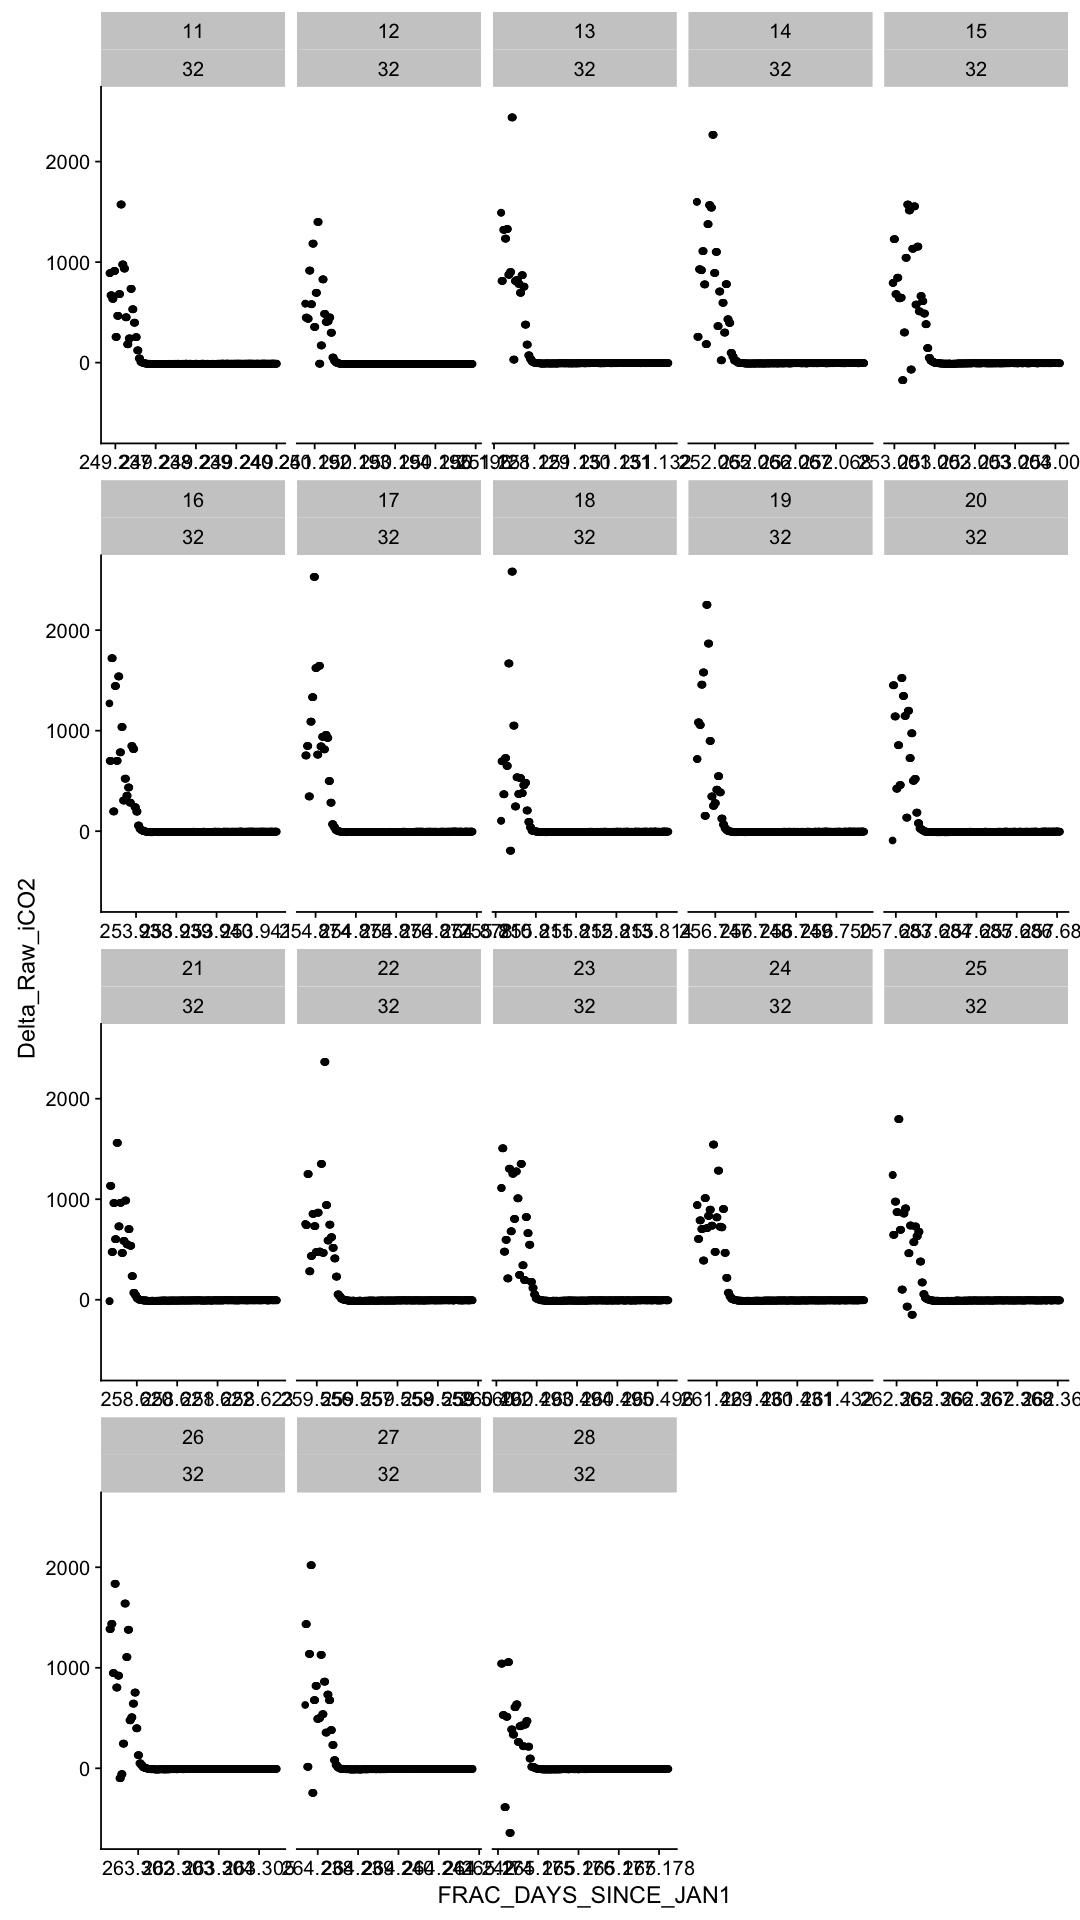

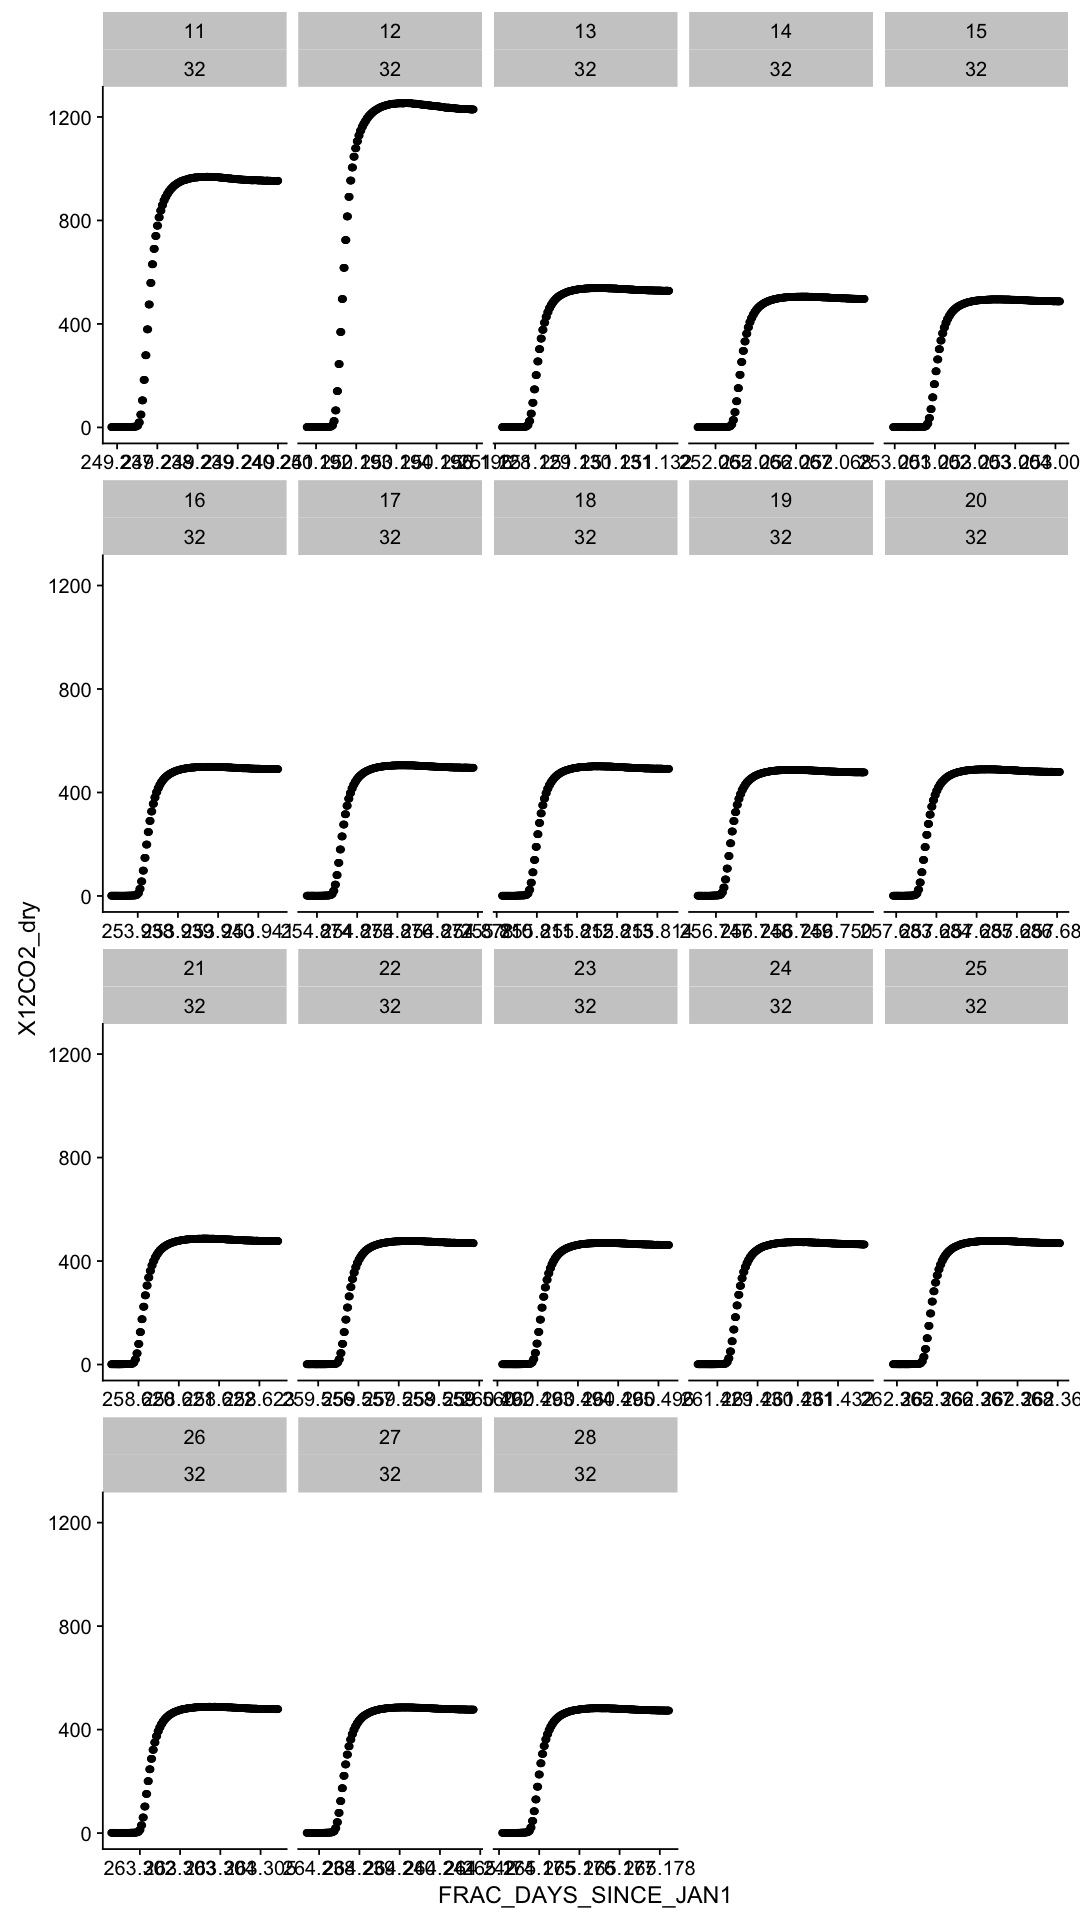

In [7]:
options(repr.plot.width=9, repr.plot.height=16)

# Looking at the data
d = pic.data %>%
    #filter(sample.rep %in% c(2,5,8))%>%
    filter(sample.test %in% c(32))%>% 
    filter(step=="analysis")
# 6 is soil 4 is OM 5 is PyOM


p = ggplot(d,aes(x=FRAC_DAYS_SINCE_JAN1,y=Delta_Raw_iCO2))
#p = ggplot(d,aes(x=FRAC_DAYS_SINCE_JAN1,y=X12CO2_dry))
p = p + geom_point()
p = p + facet_wrap(~sample.rep*sample.test,scales="free_x")
#p = p + ylim(500,600)
#p = p + ylim(0,100)
#p = p + ylim(5,8)
p

#p = ggplot(d,aes(x=FRAC_DAYS_SINCE_JAN1,y=Delta_Raw_iCO2))
p = ggplot(d,aes(x=FRAC_DAYS_SINCE_JAN1,y=X12CO2_dry))
p = p + geom_point()
p = p + facet_wrap(~sample.rep*sample.test,scales="free_x")
#p = p + ylim(500,600)
#p = p + ylim(0,100)
#p = p + ylim(0,2.5)
p

In [8]:
df = data.frame(Sample=c("a","a","a","b","b","b"), Time=c(1,2,3,1,2,3),Value=c(12,3,1,43,2,12))
dft = df %>%
    group_by(Sample)%>%
    top_n(2,Time)%>%
    mutate(MeanValue = mean(Value, na.rm = T))%>%
    top_n(1,Time)
dft
# Making sure the code below does what I want it to do

Sample Time Value MeanValue
1 a      3     1    2        
2 b      3    12    7

In [9]:
avepoints = 50
    # The number of timepoints we want to have for the average within a given set

testmean = pic.data %>%
    filter(step=="analysis")%>%
    group_by(samprepstep)%>%
    mutate(MaxCO2 = max(CO2tot, na.rm = T))%>%
    top_n(avepoints,FRAC_DAYS_SINCE_JAN1)%>%
    mutate(LateMeanCO2 = mean(CO2tot, na.rm = T))%>%
    mutate(LateMeand13C = mean(Delta_Raw_iCO2, na.rm = T))%>%
    top_n(1,FRAC_DAYS_SINCE_JAN1)%>%
    select(FRAC_DAYS_SINCE_JAN1,sample.test,sample.rep,step,samprep,samprepstep,LateMeanCO2,LateMeand13C,MaxCO2)
    # This groups the data by each sample,replicate, and step, takes the last x datapoints,
    # and calculates their average value for total CO2 and d13C
    # It reports only the final timepoint for each combination.

Warning message in max(CO2tot, na.rm = T):
“no non-missing arguments to max; returning -Inf”

In [10]:
avepoints = 6

purgemean = pic.data %>%
    filter(step=="purge")%>%
    group_by(samprepstep)%>%
    top_n(avepoints,FRAC_DAYS_SINCE_JAN1)%>%
    mutate(LateMeanCO2 = mean(CO2tot, na.rm = T))%>%
    mutate(LateMeand13C = mean(Delta_Raw_iCO2, na.rm = T))%>%
    top_n(1,FRAC_DAYS_SINCE_JAN1)%>%
    select(FRAC_DAYS_SINCE_JAN1,sample.test,sample.rep,step,samprep,samprepstep,LateMeanCO2,LateMeand13C)
    # This groups the data by each sample,replicate, and step, takes the last x datapoints,
    # and calculates their average value for total CO2 and d13C
    # It reports only the final timepoint for each combination.

purgemean = purgemean[,c("samprep","LateMeanCO2","LateMeand13C")]
setnames(purgemean, 2:3, c("purge.mean.co2", "purge.mean.d13c"))

In [11]:
#############################################################################################################
#  Reduce data to one row per sample measurement  
#############################################################################################################


# Select only the first occurence of the maximum co2 for each sample replicate
short.data = pic.data[CO2tot==maxco2,][, .SD[1], keyby=samprep][step=="analysis"]

# purge.co2 is last value during purge for each samprep
### ARE the samples stabilizing???
purge.data = pic.data[step=="purge" & !is.na(CO2tot), .SD[.N], keyby=samprep][, .(samprep, CO2tot, Delta_Raw_iCO2) ]
  # Selects the columns for each samprep with 12CO2 and the raw d13C
setnames(purge.data, 2:3, c("purge.co2", "purge.d13c"))
  # Gives the columns unique names
short.data = merge(short.data, purge.data, all.x = T)
  # Merges with the short.data so we have purge data as well.

# dilute.co2 is 1st value from each samprep (i.e. concentration in pipework before headspace gas reaches the analyser)
dilute.data = pic.data[step=="analysis" & !is.na(CO2tot), .SD[1], keyby=samprep][, .(samprep, CO2tot, Delta_Raw_iCO2) ]
setnames(dilute.data, 2:3, c("dilute.co2", "dilute.d13c"))
# I think we can use dilute.co2 as a check that there wasn't a tonne of Co2 in the lines,
# But its d13C value is all over the place and can't be trusted - ppm too low.

short.data = merge(short.data, dilute.data, all.x = T)

head(short.data)

samprep     FRAC_DAYS_SINCE_JAN1 X12CO2_dry X13CO2    Delta_Raw_iCO2
1 00001,00012 249.7401             53.90350   0.6383835 53.91739      
2 00001,00013 250.6763             55.06719   0.6494316 49.49991      
3 00001,00014 251.6125             51.82855   0.6059635 40.44536      
4 00001,00015 252.5494             51.12889   0.5993027 43.08999      
5 00001,00016 253.4856             50.04555   0.5884407 46.35523      
6 00001,00017 254.4218             51.26112   0.6026575 46.22319      
  sample.test sample.rep step     samprepstep          CO2tot   maxco2  
1 1           12         analysis 00001,00012,analysis 54.54189 54.54189
2 1           13         analysis 00001,00013,analysis 55.71662 55.71662
3 1           14         analysis 00001,00014,analysis 52.43451 52.43451
4 1           15         analysis 00001,00015,analysis 51.72819 51.72819
5 1           16         analysis 00001,00016,analysis 50.63399 50.63399
6 1           17         analysis 00001,00017,analysis 51.86378 51.86378
  purge.co2 purge.d13c dilute.co2 dilute.d13c
1 3.757810  1639.600   2.0195357    89.25229 
2 3.881320  1347.680   1.2186279  1197.19315 
3 2.710920  1844.813   0.7482433  1213.20416 
4 2.355424  1935.204   0.8091065   232.52371 
5 2.207145  1905.290   0.8338363  1680.49144 
6 2.422801  1855.040   0.7872654  2109.77647

In [12]:
testmean[!(testmean$samprep %in% short.data$samprep),]
    # Missing only the last couple of blank samples... fine
testmean[!(testmean$samprep %in% dilute.data$samprep),]
    # All there.
head(testmean[!(testmean$samprep %in% purge.data$samprep),])
    # Missing everything from step 11 (because there was no prior purge data)

FRAC_DAYS_SINCE_JAN1 sample.test sample.rep step     samprep    
1 250.6495             63          12         analysis 00063,00012
2 251.6005             64          13         analysis 00064,00013
  samprepstep          LateMeanCO2 LateMeand13C MaxCO2  
1 00063,00012,analysis 217.2035     39.45558    217.3882
2 00064,00013,analysis 102.7089    102.40916    103.0561

FRAC_DAYS_SINCE_JAN1 sample.test sample.rep step samprep samprepstep
     LateMeanCO2 LateMeand13C MaxCO2

FRAC_DAYS_SINCE_JAN1 sample.test sample.rep step     samprep    
1 248.8021             2           11         analysis 00002,00011
2 248.8167             3           11         analysis 00003,00011
3 248.8313             4           11         analysis 00004,00011
4 248.8460             5           11         analysis 00005,00011
5 248.8606             6           11         analysis 00006,00011
6 248.8752             7           11         analysis 00007,00011
  samprepstep          LateMeanCO2 LateMeand13C MaxCO2   
1 00002,00011,analysis  157.4820     3.4037472   164.6341
2 00003,00011,analysis  165.5894    -0.2640871   171.8362
3 00004,00011,analysis 1005.3244   661.5901135  1058.4181
4 00005,00011,analysis  103.2864    90.9652257   104.3642
5 00006,00011,analysis  210.4678     0.2759934   220.7256
6 00007,00011,analysis  928.4223   448.9914052   966.0323

In [13]:
testmean = testmean[,c("samprep","LateMeanCO2","LateMeand13C")]
setnames(testmean, 2:3, c("mean.co2", "mean.d13c"))
short.data = merge(short.data, testmean, all.x = T)

In [14]:
short.data = merge(short.data, purgemean, all.x = T)

In [15]:
short.data = short.data%>%
    select(samprep,sample.test,sample.rep,FRAC_DAYS_SINCE_JAN1,CO2tot,Delta_Raw_iCO2,purge.co2,purge.d13c,dilute.co2,dilute.d13c,mean.co2,mean.d13c,purge.mean.co2,purge.mean.d13c)
colnames(short.data)[6]="d13c"

In [16]:
# Adding the fraction of volume occupied by sample
short.data <- merge(short.data, frac6, all.x = T, by='sample.test')

In [17]:
# Adding all the sample data
short.data = merge(short.data, SampleData, all.x = T, by='sample.test')
head(short.data)

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot   d13c    
1 1           00001,00012 12         249.7401             54.54189 53.91739
2 1           00001,00013 13         250.6763             55.71662 49.49991
3 1           00001,00014 14         251.6125             52.43451 40.44536
4 1           00001,00015 15         252.5494             51.72819 43.08999
5 1           00001,00016 16         253.4856             50.63399 46.35523
6 1           00001,00017 17         254.4218             51.86378 46.22319
  purge.co2 purge.d13c dilute.co2 dilute.d13c ⋯ anions.bromide anions.nitrate
1 3.757810  1639.600   2.0195357    89.25229  ⋯ NA             NA            
2 3.881320  1347.680   1.2186279  1197.19315  ⋯ NA             NA            
3 2.710920  1844.813   0.7482433  1213.20416  ⋯ NA             NA            
4 2.355424  1935.204   0.8091065   232.52371  ⋯ NA             NA            
5 2.207145  1905.290   0.8338363  1680.49144  ⋯ NA             NA            
6 2.422801  1855.040   0.7872654  2109.77647  ⋯ NA             NA            
  anions.phosphate anions.sulfate PLFA.bacterial PLFA.actinomycetes PLFA.fungi
1 NA               NA             NA             NA                 NA        
2 NA               NA             NA             NA                 NA        
3 NA               NA             NA             NA                 NA        
4 NA               NA             NA             NA                 NA        
5 NA               NA             NA             NA                 NA        
6 NA               NA             NA             NA                 NA        
  PLFA.fungBactRatio PLFA.actinoBactRatio CNratio
1 NA                 NA                   NA     
2 NA                 NA                   NA     
3 NA                 NA                   NA     
4 NA                 NA                   NA     
5 NA                 NA                   NA     
6 NA                 NA                   NA

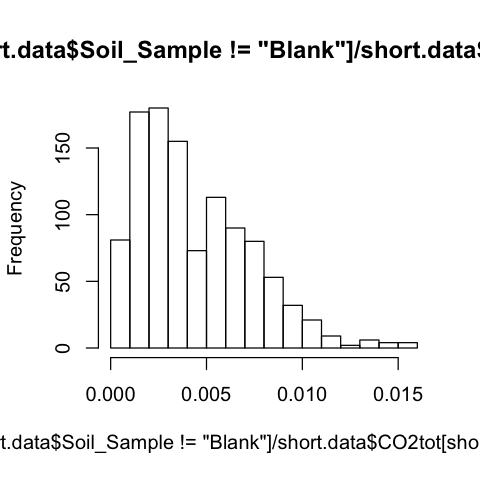

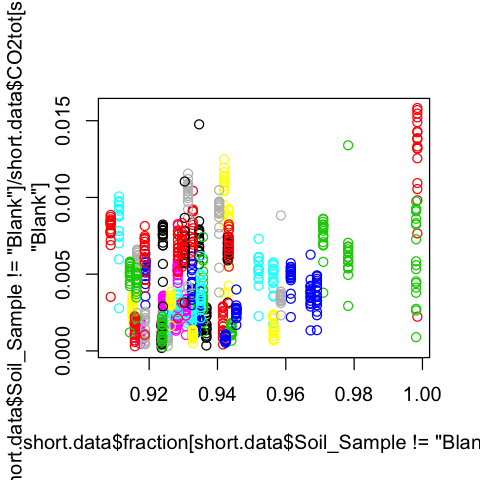

In [18]:
# Check the fraction that the dilute.co2 is of the total co2
options(repr.plot.width=4, repr.plot.height=4)
hist(short.data$dilute.co2[short.data$Soil_Sample!="Blank"] / short.data$CO2tot[short.data$Soil_Sample!="Blank"])

# For the non-blank jars, the maximum values are <2% of the total data.
# So, I'd say we could subtract the CO2, but don't really need to...
# The question is if we can subtract the CO2 without adjusting the d13C.
    # Because we can't adjust the d13C because we don't have confidence in the values...

plot(short.data$fraction[short.data$Soil_Sample!="Blank"],short.data$dilute.co2[short.data$Soil_Sample!="Blank"] / short.data$CO2tot[short.data$Soil_Sample!="Blank"],col=short.data$Soil_Sample[short.data$Soil_Sample!="Blank"])
# It's not really related to the fraction length either...

In [19]:
colnames(short.data)

[1] "sample.test"                     "samprep"                        
 [3] "sample.rep"                      "FRAC_DAYS_SINCE_JAN1"           
 [5] "CO2tot"                          "d13c"                           
 [7] "purge.co2"                       "purge.d13c"                     
 [9] "dilute.co2"                      "dilute.d13c"                    
[11] "mean.co2"                        "mean.d13c"                      
[13] "purge.mean.co2"                  "purge.mean.d13c"                
[15] "fraction"                        "Tube_ID"                        
[17] "Seq_ID"                          "Proj_ID"                        
[19] "Soil_Rep_Day"                    "Soil_Rep_Day_Trtmt"             
[21] "Qorpak_ID"                       "Amdmt_mg"                       
[23] "Soil_g"                          "Soil_Trtmt"                     
[25] "Soil_Rep"                        "Soil_Sample"                    
[27] "Amdmt"                           "Date"                           
[29] "Day"                             "Mason_Jar"                      
[31] "Water_mL"                        "Full_ID"                        
[33] "Corresponding_control_Qorpak_ID" "Corresponding_control_Mason_ID" 
[35] "Picarro_ID"                      "Amdmt_d13C"                     
[37] "Amdmt_C_frac"                    "lat_lon"                        
[39] "depth"                           "Single.or.Composite.Core"       
[41] "US_State"                        "description"                    
[43] "country"                         "elevation"                      
[45] "env_biome"                       "env_feature"                    
[47] "NEON_soil_descrip"               "env_material"                   
[49] "horizon"                         "host_subject_id"                
[51] "NEON_tower_lat"                  "NEON_tower_long"                
[53] "ph"                              "project_name"                   
[55] "water_content_soil"              "CEC"                            
[57] "organicMatter"                   "Ca"                             
[59] "Mg"                              "Na"                             
[61] "K"                               "totalCarbon"                    
[63] "totalNitrogen"                   "micBiomass"                     
[65] "anions.chloride"                 "anions.nitrite"                 
[67] "anions.bromide"                  "anions.nitrate"                 
[69] "anions.phosphate"                "anions.sulfate"                 
[71] "PLFA.bacterial"                  "PLFA.actinomycetes"             
[73] "PLFA.fungi"                      "PLFA.fungBactRatio"             
[75] "PLFA.actinoBactRatio"            "CNratio"

In [20]:
# headspace CO2 is measured CO2, adjusted for the fraction of CO2 from pipework dilutant
short.data[, headspace.co2  := (CO2tot - (1-fraction) * dilute.co2) / fraction ]
short.data[, headspace.mean.co2  := (mean.co2 - (1-fraction) * dilute.co2) / fraction ]

short.data[, respired.co2 := headspace.co2 - purge.co2]
short.data[, respired.mean.co2 := headspace.mean.co2 - purge.mean.co2]
  # then subtract ppm co2 that was in the jar to begin with

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

In [21]:
# So, we have the headspace co2, which is the co2 minus whatever was in the pipeline at the start of analysis
# We have the respired co2, which is the co2 minus the pipeline, minus the values when the valves closed
    # at the end of the previous timepoint.
# Now we need to calculate what the d13C of the respired co2 should be, by subtracting the purge co2 13C

In [22]:
#d13c = fPurged*d13CPurged + fRespired*d13CRespired
#d13C - fPurged*d13CPurged = fRespired*d13CRespired
#d13C - fPurged*d13CPurged = (1-fPurged)*d13CRespired
#(d13C - fPurged*d13CPurged) / (1-fPurged) = d13CRespired

short.data[, fPurged.mean := purge.mean.co2/headspace.mean.co2]
short.data[, fPurged := purge.co2/headspace.co2]
# Calculate the fPurged; we have d13C, we have d13CPurged.

short.data[, respired.d13c := ((d13c-fPurged*purge.d13c) / (1-fPurged))]
short.data[, respired.mean.d13c := ((mean.d13c-fPurged.mean*purge.mean.d13c) / (1-fPurged.mean))]

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1    1           00001,00012 12         249.7401              54.54189 
2    1           00001,00013 13         250.6763              55.71662 
3    1           00001,00014 14         251.6125              52.43451 
4    1           00001,00015 15         252.5494              51.72819 
5    1           00001,00016 16         253.4856              50.63399 
6    1           00001,00017 17         254.4218              51.86378 
7    1           00001,00018 18         255.3581              52.63373 
8    1           00001,00019 19         256.2946              52.24917 
9    1           00001,00020 20         257.2311              54.64447 
10   1           00001,00021 21         258.1673              55.44780 
11   1           00001,00022 22         259.1040              53.67722 
12   1           00001,00023 23         260.0404              53.49529 
13   1           00001,00024 24         260.9767              53.11059 
14   1           00001,00025 25         261.9130              52.01721 
15   1           00001,00026 26         262.8493              54.61041 
16   1           00001,00027 27         263.7860              54.45890 
17   1           00001,00028 28         264.7223              55.19501 
18   2           00002,00011 11         248.7995             164.63406 
19   2           00002,00012 12         249.7544             331.51776 
20   2           00002,00013 13         250.6909             167.72838 
21   2           00002,00014 14         251.6273             165.97275 
22   2           00002,00015 15         252.5637             159.38645 
23   2           00002,00016 16         253.5002             155.22643 
24   2           00002,00017 17         254.4364             157.98711 
25   2           00002,00018 18         255.3728             157.53548 
26   2           00002,00019 19         256.3091             155.17601 
27   2           00002,00020 20         257.2455             154.20399 
28   2           00002,00021 21         258.1819             154.96835 
29   2           00002,00022 22         259.1185             151.72979 
30   2           00002,00023 23         260.0549             150.22832 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 63          00063,00016 16         254.3951               47.07259
1121 63          00063,00017 17         255.3313               45.91231
1122 63          00063,00018 18         256.2675               43.65369
1123 63          00063,00019 19         257.2039               44.66975
1124 63          00063,00020 20         258.1403               45.00104
1125 63          00063,00021 21         259.0769               44.18872
1126 63          00063,00022 22         260.0132               43.60615
1127 63          00063,00023 23         260.9496               43.58740
1128 63          00063,00024 24         261.8861               43.66073
1129 63          00063,00025 25         262.8223               43.82590
1130 63          00063,00026 26         263.7590               43.67400
1131 63          00063,00027 27         264.6953               44.50404
1132 63          00063,00028 28         265.6315               44.00116
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

In [23]:
colnames(short.data)

[1] "sample.test"                     "samprep"                        
 [3] "sample.rep"                      "FRAC_DAYS_SINCE_JAN1"           
 [5] "CO2tot"                          "d13c"                           
 [7] "purge.co2"                       "purge.d13c"                     
 [9] "dilute.co2"                      "dilute.d13c"                    
[11] "mean.co2"                        "mean.d13c"                      
[13] "purge.mean.co2"                  "purge.mean.d13c"                
[15] "fraction"                        "Tube_ID"                        
[17] "Seq_ID"                          "Proj_ID"                        
[19] "Soil_Rep_Day"                    "Soil_Rep_Day_Trtmt"             
[21] "Qorpak_ID"                       "Amdmt_mg"                       
[23] "Soil_g"                          "Soil_Trtmt"                     
[25] "Soil_Rep"                        "Soil_Sample"                    
[27] "Amdmt"                           "Date"                           
[29] "Day"                             "Mason_Jar"                      
[31] "Water_mL"                        "Full_ID"                        
[33] "Corresponding_control_Qorpak_ID" "Corresponding_control_Mason_ID" 
[35] "Picarro_ID"                      "Amdmt_d13C"                     
[37] "Amdmt_C_frac"                    "lat_lon"                        
[39] "depth"                           "Single.or.Composite.Core"       
[41] "US_State"                        "description"                    
[43] "country"                         "elevation"                      
[45] "env_biome"                       "env_feature"                    
[47] "NEON_soil_descrip"               "env_material"                   
[49] "horizon"                         "host_subject_id"                
[51] "NEON_tower_lat"                  "NEON_tower_long"                
[53] "ph"                              "project_name"                   
[55] "water_content_soil"              "CEC"                            
[57] "organicMatter"                   "Ca"                             
[59] "Mg"                              "Na"                             
[61] "K"                               "totalCarbon"                    
[63] "totalNitrogen"                   "micBiomass"                     
[65] "anions.chloride"                 "anions.nitrite"                 
[67] "anions.bromide"                  "anions.nitrate"                 
[69] "anions.phosphate"                "anions.sulfate"                 
[71] "PLFA.bacterial"                  "PLFA.actinomycetes"             
[73] "PLFA.fungi"                      "PLFA.fungBactRatio"             
[75] "PLFA.actinoBactRatio"            "CNratio"                        
[77] "headspace.co2"                   "headspace.mean.co2"             
[79] "respired.co2"                    "respired.mean.co2"              
[81] "fPurged.mean"                    "fPurged"                        
[83] "respired.d13c"                   "respired.mean.d13c"

In [24]:
# Next, we need to select the relevant mean to which to compare the amended soils.
# Including options - mean is whether I took the mean values during the measurement cycle
#    - paired is whether I took only the exact soil sample, to match (as opposed to average of all soils
#       at that timepoint)
test = short.data 
for (i in 1:dim(short.data )[1]){
    Soil_Trtmt = short.data $Soil_Trtmt[i]
    Soil_Sample = short.data $Soil_Sample[i]
    sample.rep = short.data $sample.rep[i]
    short.data$ref.d13c[i] = mean(short.data $respired.d13c[short.data $Amdmt=="Soil" 
                                               & short.data $Soil_Trtmt == Soil_Trtmt 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.mean.d13c[i] = mean(short.data $respired.mean.d13c[short.data $Amdmt=="Soil" 
                                            & short.data $Soil_Trtmt == Soil_Trtmt 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.paired.d13c[i] = mean(short.data $respired.d13c[short.data $Amdmt=="Soil" 
                                               & short.data $Soil_Sample == Soil_Sample 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.paired.mean.d13c[i] = mean(short.data $respired.mean.d13c[short.data $Amdmt=="Soil" 
                                            & short.data $Soil_Sample == Soil_Sample 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.co2[i] = mean(short.data $respired.co2[short.data $Amdmt=="Soil" 
                                               & short.data $Soil_Trtmt == Soil_Trtmt 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.mean.co2[i] = mean(short.data $respired.mean.co2[short.data $Amdmt=="Soil" 
                                            & short.data $Soil_Trtmt == Soil_Trtmt 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.paired.co2[i] = mean(short.data $respired.co2[short.data $Amdmt=="Soil" 
                                               & short.data $Soil_Sample == Soil_Sample 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    short.data$ref.paired.mean.co2[i] = mean(short.data $respired.mean.co2[short.data $Amdmt=="Soil" 
                                            & short.data $Soil_Sample == Soil_Sample 
                                              & short.data $sample.rep == sample.rep], na.rm=TRUE)
    
    
}
short.data  = short.data  %>%
    arrange(Soil_Trtmt,sample.rep,Amdmt)
short.data [test$Soil_Trtmt=="AK",]

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot   
36    12          00012,00013 13         250.8374             199.2229 
37     4          00004,00014 14         251.6565             301.8268 
38     7          00007,00014 14         251.7004             443.5133 
39    10          00010,00014 14         251.7444             323.6687 
40    61          00061,00014 14         252.4930             156.6854 
41     5          00005,00014 14         251.6713             155.1075 
42     8          00008,00014 14         251.7152             203.9908 
43    11          00011,00014 14         251.7591             177.2853 
44    62          00062,00014 14         252.5074             155.4768 
45     3          00003,00014 14         251.6419             115.1825 
46     6          00006,00014 14         251.6857             168.0312 
47     9          00009,00014 14         251.7299             274.7634 
48    12          00012,00014 14         251.7736             178.4103 
49     4          00004,00015 15         252.5932             243.9411 
50     7          00007,00015 15         252.6371             423.0818 
51    10          00010,00015 15         252.6810             294.4200 
52    61          00061,00015 15         253.4294             141.6210 
53     5          00005,00015 15         252.6078             147.8452 
54     8          00008,00015 15         252.6516             199.1532 
55    11          00011,00015 15         252.6957             172.9851 
56    62          00062,00015 15         253.4439             150.3583 
57     3          00003,00015 15         252.5785             106.6913 
58     6          00006,00015 15         252.6224             160.5874 
59     9          00009,00015 15         252.6665             262.1493 
60    12          00012,00015 15         252.7104             171.9790 
61     4          00004,00016 16         253.5294             207.7779 
62     7          00007,00016 16         253.5734             400.9749 
63    10          00010,00016 16         253.6174             279.8323 
64    61          00061,00016 16         254.3658             138.4384 
65     5          00005,00016 16         253.5445             140.1425 
⋮     ⋮           ⋮           ⋮          ⋮                    ⋮        
1103  44          00044,00026 26         263.4810              367.2214
1104  47          00047,00026 26         263.5249              481.3548
1105  39          00039,00026 26         263.4063              279.7193
1106  42          00042,00026 26         263.4517              368.3465
1107  45          00045,00026 26         263.4956              202.0392
1108  48          00048,00026 26         263.5395              290.8984
1109  37          00037,00027 27         264.3133             1018.1555
1110  40          00040,00027 27         264.3589              606.8762
1111  43          00043,00027 27         264.4027              771.1607
1112  46          00046,00027 27         264.4455              980.6370
1113  38          00038,00027 27         264.3282              275.2271
1114  41          00041,00027 27         264.3735              243.1166
1115  44          00044,00027 27         264.4173              360.9572
NA    NA          NA          NA               NA                    NA
NA.1  NA          NA          NA               NA                    NA
NA.2  NA          NA          NA               NA                    NA
NA.3  NA          NA          NA               NA                    NA
NA.4  NA          NA          NA               NA                    NA
NA.5  NA          NA          NA               NA                    NA
NA.6  NA          NA          NA               NA                    NA
NA.7  NA          NA          NA               NA                    NA
NA.8  NA          NA          NA               NA                    NA
NA.9  NA          NA          NA               NA                    NA
NA.10 NA          NA          NA              

In [25]:
colnames(short.data)

[1] "sample.test"                     "samprep"                        
 [3] "sample.rep"                      "FRAC_DAYS_SINCE_JAN1"           
 [5] "CO2tot"                          "d13c"                           
 [7] "purge.co2"                       "purge.d13c"                     
 [9] "dilute.co2"                      "dilute.d13c"                    
[11] "mean.co2"                        "mean.d13c"                      
[13] "purge.mean.co2"                  "purge.mean.d13c"                
[15] "fraction"                        "Tube_ID"                        
[17] "Seq_ID"                          "Proj_ID"                        
[19] "Soil_Rep_Day"                    "Soil_Rep_Day_Trtmt"             
[21] "Qorpak_ID"                       "Amdmt_mg"                       
[23] "Soil_g"                          "Soil_Trtmt"                     
[25] "Soil_Rep"                        "Soil_Sample"                    
[27] "Amdmt"                           "Date"                           
[29] "Day"                             "Mason_Jar"                      
[31] "Water_mL"                        "Full_ID"                        
[33] "Corresponding_control_Qorpak_ID" "Corresponding_control_Mason_ID" 
[35] "Picarro_ID"                      "Amdmt_d13C"                     
[37] "Amdmt_C_frac"                    "lat_lon"                        
[39] "depth"                           "Single.or.Composite.Core"       
[41] "US_State"                        "description"                    
[43] "country"                         "elevation"                      
[45] "env_biome"                       "env_feature"                    
[47] "NEON_soil_descrip"               "env_material"                   
[49] "horizon"                         "host_subject_id"                
[51] "NEON_tower_lat"                  "NEON_tower_long"                
[53] "ph"                              "project_name"                   
[55] "water_content_soil"              "CEC"                            
[57] "organicMatter"                   "Ca"                             
[59] "Mg"                              "Na"                             
[61] "K"                               "totalCarbon"                    
[63] "totalNitrogen"                   "micBiomass"                     
[65] "anions.chloride"                 "anions.nitrite"                 
[67] "anions.bromide"                  "anions.nitrate"                 
[69] "anions.phosphate"                "anions.sulfate"                 
[71] "PLFA.bacterial"                  "PLFA.actinomycetes"             
[73] "PLFA.fungi"                      "PLFA.fungBactRatio"             
[75] "PLFA.actinoBactRatio"            "CNratio"                        
[77] "headspace.co2"                   "headspace.mean.co2"             
[79] "respired.co2"                    "respired.mean.co2"              
[81] "fPurged.mean"                    "fPurged"                        
[83] "respired.d13c"                   "respired.mean.d13c"             
[85] "ref.d13c"                        "ref.mean.d13c"                  
[87] "ref.paired.d13c"                 "ref.paired.mean.d13c"           
[89] "ref.co2"                         "ref.mean.co2"                   
[91] "ref.paired.co2"                  "ref.paired.mean.co2"

In [26]:
# Then, the next step is to do the actual partitioning.
# This is probably easiest to do selecting which options we want, otherwise too many values.
# However, it's really whether it's paired or mean.

## Calculations:

#d13Ctot = d13Csoil*fractSoil + d13Camdmt*fractAmdmt
#d13Ctot = d13Csoil*fractSoil + d13Camdmt*(1-fractSoil)
#d13Ctot = d13Csoil*fractSoil + d13Camdmt-d13Camdmt*fractSoil
#d13Ctot - d13Camdmt = (d13Csoil-d13Camdmt)*fractSoil
#(d13Ctot - d13Camdmt) / (d13Csoil-d13Camdmt) = fractSoil

## Basic method (max), not paired ref soil d13C
for (i in 1:dim(short.data)[1]){
    if (is.na(short.data$Amdmt[i])){
        short.data$fractSoil[i] = 1
    }
    if (short.data$Amdmt[i] %in% c("PyOM","OM")){
        d13Ctot = short.data$respired.d13c[i]
        #d13Ctot = short.data$respired.mean.d13C[i]
        
        d13Camdmt = short.data$Amdmt_d13C[i]

        d13Csoil = short.data$ref.d13c[i]
        #d13Csoil = short.data$ref.mean.d13c[i]
        #d13Csoil = short.data$ref.paired.d13c[i]
        #d13Csoil = short.data$ref.paired.meand13c[i]
        
        short.data$fractSoil[i] = ((d13Ctot - d13Camdmt) / (d13Csoil-d13Camdmt))
        }
    else {short.data$fractSoil[i] = 1}
    }

## Basic method (max), with paired ref soil d13C
for (i in 1:dim(short.data)[1]){
    if (is.na(short.data$Amdmt[i])){
        short.data$fractSoil.paired[i] = 1
    }
    if (short.data$Amdmt[i] %in% c("PyOM","OM")){
        d13Ctot = short.data$respired.d13c[i]
        #d13Ctot = short.data$respired.mean.d13C[i]
        
        d13Camdmt = short.data$Amdmt_d13C[i]

        #d13Csoil = short.data$ref.d13c[i]
        #d13Csoil = short.data$ref.mean.d13c[i]
        d13Csoil = short.data$ref.paired.d13c[i]
        #d13Csoil = short.data$ref.paired.meand13c[i]
        
        short.data$fractSoil.paired[i] = ((d13Ctot - d13Camdmt) / (d13Csoil-d13Camdmt))
        }
    else {short.data$fractSoil.paired[i] = 1}
    }

## Mean, not paired ref soil d13C
for (i in 1:dim(short.data)[1]){
    if (is.na(short.data$Amdmt[i])){
        short.data$fractSoil.mean[i] = 1
    }
    if (short.data$Amdmt[i] %in% c("PyOM","OM")){
        #d13Ctot = short.data$respired.d13c[i]
        d13Ctot = short.data$respired.mean.d13c[i]
        
        d13Camdmt = short.data$Amdmt_d13C[i]

        #d13Csoil = short.data$ref.d13c[i]
        d13Csoil = short.data$ref.mean.d13c[i]
        #d13Csoil = short.data$ref.paired.d13c[i]
        #d13Csoil = short.data$ref.paired.meand13c[i]
        
        short.data$fractSoil.mean[i] = ((d13Ctot - d13Camdmt) / (d13Csoil-d13Camdmt))
        }
    else {short.data$fractSoil.mean[i] = 1}
    }

## Mean, with paired ref soil d13C
for (i in 1:dim(short.data)[1]){
    if (is.na(short.data$Amdmt[i])){
        short.data$fractSoil.paired.mean[i] = 1
    }
    if (short.data$Amdmt[i] %in% c("PyOM","OM")){
        #d13Ctot = short.data$respired.d13c[i]
        d13Ctot = short.data$respired.mean.d13c[i]
        
        d13Camdmt = short.data$Amdmt_d13C[i]

        #d13Csoil = short.data$ref.d13c[i]
        #d13Csoil = short.data$ref.mean.d13c[i]
        #d13Csoil = short.data$ref.paired.d13c[i]
        d13Csoil = short.data$ref.paired.mean.d13c[i]
        
        short.data$fractSoil.paired.mean[i] = ((d13Ctot - d13Camdmt) / (d13Csoil-d13Camdmt))
        }
    else {short.data$fractSoil.paired.mean[i] = 1}
    }


In [27]:
min(short.data$fractSoil[short.data$Amdmt=="PyOM"], na.rm=TRUE)
max(short.data$fractSoil[short.data$Amdmt=="PyOM"], na.rm=TRUE)
min(short.data$fractSoil[short.data$Amdmt=="OM"], na.rm=TRUE)
max(short.data$fractSoil[short.data$Amdmt=="OM"], na.rm=TRUE)
min(short.data$fractSoil[short.data$Amdmt=="Soil"], na.rm=TRUE)
max(short.data$fractSoil[short.data$Amdmt=="Soil"], na.rm=TRUE)
# Ok, so no negative values - that's good.

[1] 0.8869655

[1] 0.9966927

[1] 0.1279347

[1] 0.91928

[1] 1

[1] 1

In [28]:
short.data$Soil.CO2 = short.data$respired.co2 * short.data$fractSoil
short.data$Amdmt.CO2 = short.data$respired.co2 * (1-short.data$fractSoil)

short.data$Soil.CO2.paired = short.data$respired.co2 * short.data$fractSoil.paired
short.data$Amdmt.CO2.paired = short.data$respired.co2 * (1-short.data$fractSoil.paired)

short.data$Soil.CO2.mean = short.data$respired.mean.co2 * short.data$fractSoil.mean
short.data$Amdmt.CO2.mean = short.data$respired.mean.co2 * (1-short.data$fractSoil.mean)

short.data$Soil.CO2.paired.mean = short.data$respired.mean.co2 * short.data$fractSoil.paired.mean
short.data$Amdmt.CO2.paired.mean = short.data$respired.mean.co2 * (1-short.data$fractSoil.paired.mean)

Warning message:
“Removed 60 rows containing missing values (geom_point).”

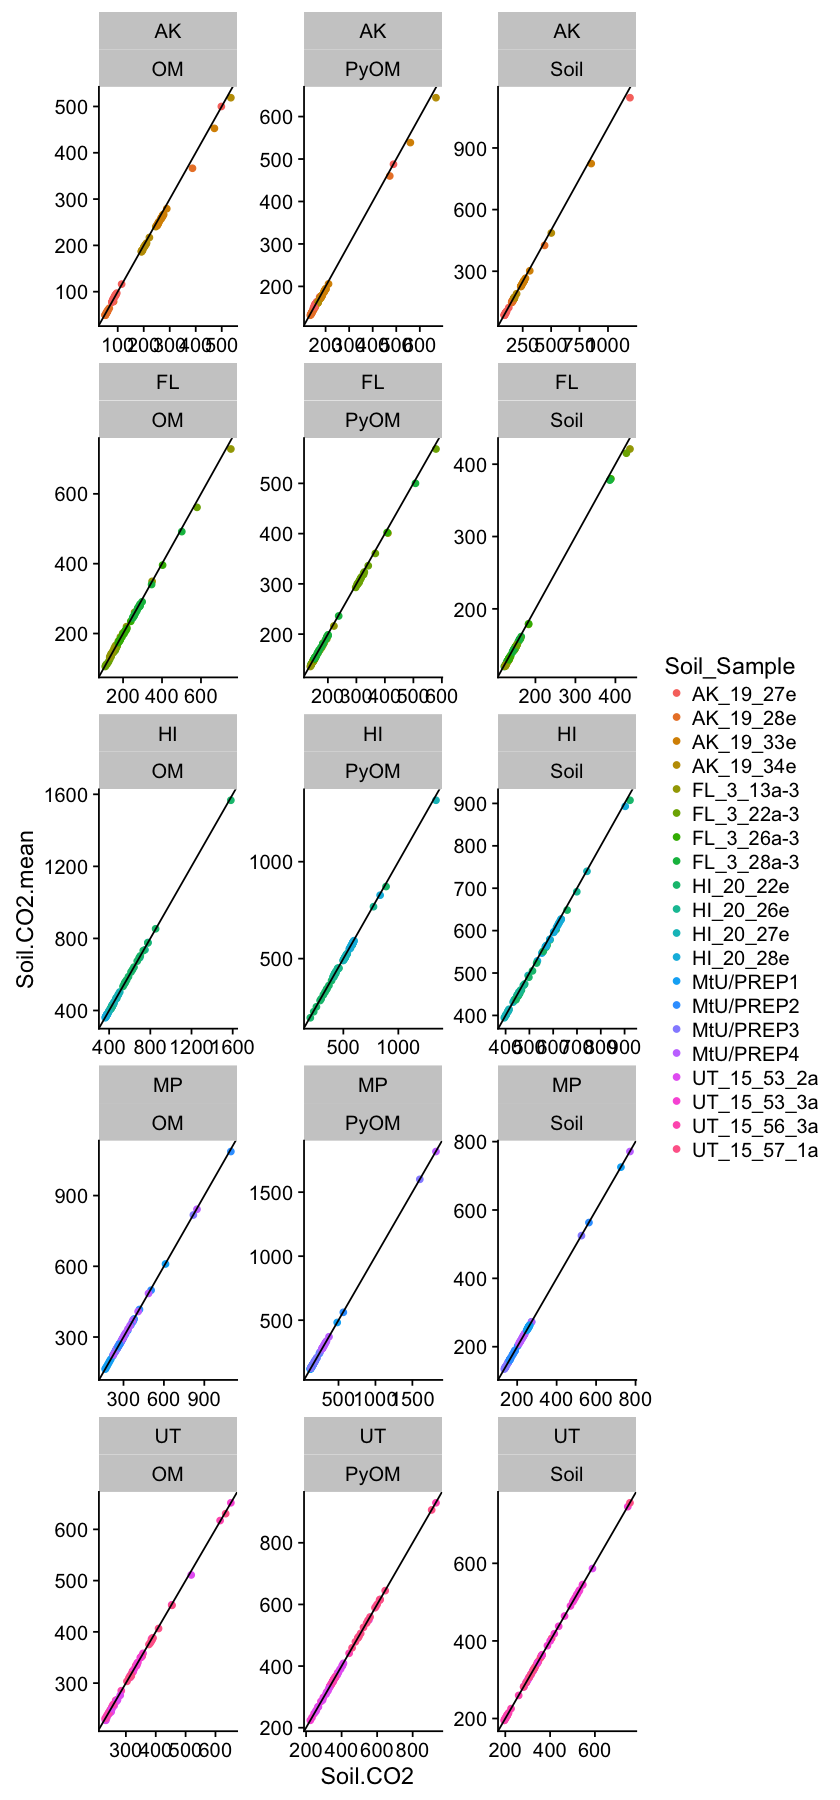

In [29]:
options(repr.plot.width=7, repr.plot.height=15)

df = short.data%>%
    filter(Soil_Sample !="Blank")

p = ggplot(df,aes(x=Soil.CO2,y=Soil.CO2.mean, colour=Soil_Sample))
p = p + geom_point()
p = p + facet_wrap(~Soil_Trtmt*Amdmt, scales="free",ncol=3)
p = p + geom_abline(slope=1, intercept=0)
p

# Choices make little difference for the OM treatments, or for soil respiration in general.
# More important for the PyOM treatments. Leaning toward mean and paired.

Warning message:
“Removed 66 rows containing missing values (geom_point).”

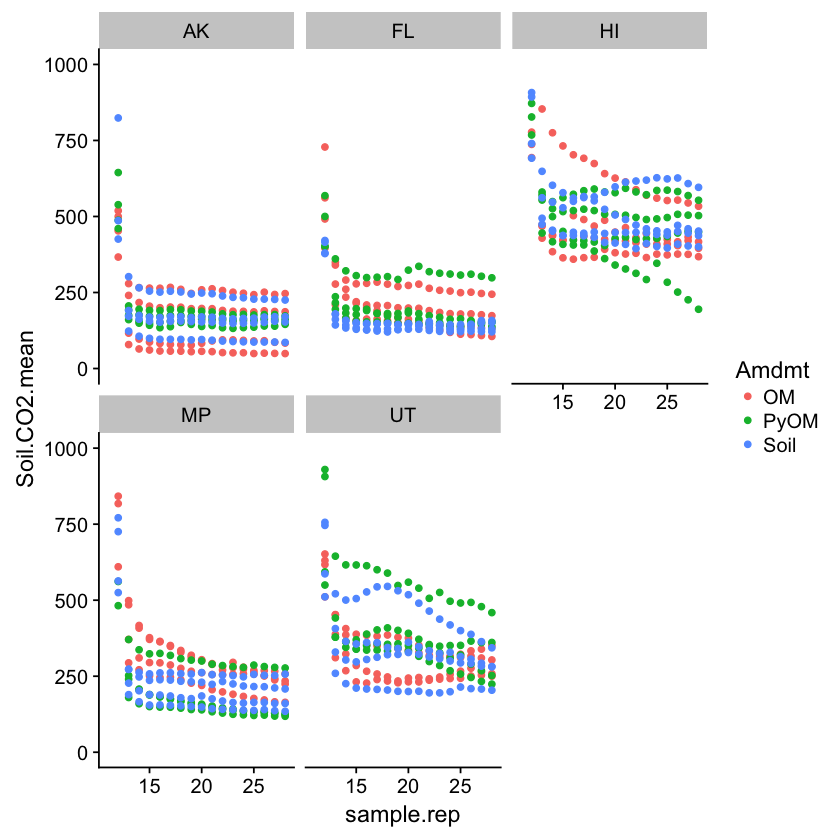

In [30]:
options(repr.plot.width=7, repr.plot.height=7)
# Should be able to plot CO2 at each timestep
df = short.data%>%
    filter(Soil_Sample !="Blank")

p = ggplot(df,aes(x=sample.rep,y=Soil.CO2.mean, colour=Amdmt))
p = p + geom_point()
p = p + facet_wrap(~Soil_Trtmt, ncol=3)
p = p + ylim(0,1000)
p

In [31]:
# Next step is to convert to mg CO2-C
# and mgCO2-C / g soil; mgCO2-C / mg soil C
# and mg CO2-C / g amdmt; mg CO2-C / mg amdmt C

In [32]:
#############################################################################################################
#  Convert co2 concentration to mass, and normalize per unit soil and per unit total initial carbon 
#############################################################################################################

# Looking at unpaired mean
short.data = data.table(short.data)
short.data[, Soil.CO2.mean.mg := Soil.CO2.mean * jar.headspace.volume * co2.density_30C * co2.carbon.frac] 
short.data[, Soil.CO2.mean.mg.per.gram.soil := Soil.CO2.mean.mg / as.numeric(paste(Soil_g))]
short.data[, Amdmt.CO2.mean.mg := Amdmt.CO2.mean * jar.headspace.volume * co2.density_30C * co2.carbon.frac] 
short.data[, Amdmt.CO2.mean.mg.per.mg.amdmt := Amdmt.CO2.mean.mg / as.numeric(paste(Amdmt_mg))]
#short.data[, respiredc_perunit_C := respired.co2.mg / jar_carbon]

# Looking at paired mean
short.data[, Soil.CO2.paired.mean.mg := Soil.CO2.paired.mean * jar.headspace.volume * co2.density_30C * co2.carbon.frac] 
short.data[, Soil.CO2.paired.mean.mg.per.gram.soil := Soil.CO2.paired.mean.mg / as.numeric(paste(Soil_g))]
short.data[, Amdmt.CO2.paired.mean.mg := Amdmt.CO2.paired.mean * jar.headspace.volume * co2.density_30C * co2.carbon.frac] 
short.data[, Amdmt.CO2.paired.mean.mg.per.mg.amdmt := Amdmt.CO2.paired.mean.mg / as.numeric(paste(Amdmt_mg))]

# Looking at unpaired max
short.data[, Soil.CO2.mg := Soil.CO2 * jar.headspace.volume * co2.density_30C * co2.carbon.frac] 
short.data[, Soil.CO2.mg.per.gram.soil := Soil.CO2.mg / as.numeric(paste(Soil_g))]
short.data[, Amdmt.CO2.mg := Amdmt.CO2 * jar.headspace.volume * co2.density_30C * co2.carbon.frac] 
short.data[, Amdmt.CO2.mg.per.mg.amdmt := Amdmt.CO2.mg / as.numeric(paste(Amdmt_mg))]

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00011 11         248.8287             1058.4181 
2     7          00007,00011 11         248.8729              966.0323 
3    10          00010,00011 11         248.9168              764.8120 
4    61          00061,00011 11         249.6653              266.0973 
5     5          00005,00011 11         248.8443              104.3642 
6     8          00008,00011 11         248.8874              337.5615 
7    11          00011,00011 11         248.9315              266.9271 
8    62          00062,00011 11         249.6799              208.9764 
9     3          00003,00011 11         248.8141              171.8362 
10    6          00006,00011 11         248.8582              220.7256 
11    9          00009,00011 11         248.9037              194.8677 
12   12          00012,00011 11         248.9461              259.2499 
13    4          00004,00012 12         249.7838              741.3061 
14    7          00007,00012 12         249.8277              747.7710 
15   10          00010,00012 12         249.8717              681.3038 
16   61          00061,00012 12         250.6200              562.5411 
17    5          00005,00012 12         249.7984              473.4184 
18    8          00008,00012 12         249.8423              548.4243 
19   11          00011,00012 12         249.8863              623.1565 
20   62          00062,00012 12         250.6348              464.7762 
21    3          00003,00012 12         249.7690             1197.6613 
22    6          00006,00012 12         249.8131              434.3929 
23    9          00009,00012 12         249.8571              832.7290 
24   12          00012,00012 12         249.9009              486.8767 
25    4          00004,00013 13         250.7201              397.0766 
26    7          00007,00013 13         250.7640              481.9819 
27   10          00010,00013 13         250.8080              370.3032 
28   61          00061,00013 13         251.5566              184.9552 
29    5          00005,00013 13         250.7353              171.2860 
30    8          00008,00013 13         250.7788              218.8417 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1120 48          00048,00027 27         264.4759              278.37640
1121 37          00037,00028 28         265.2497              956.42979
1122 40          00040,00028 28         265.2953              608.04439
1123 43          00043,00028 28         265.3392              746.53126
1124 46          00046,00028 28         265.3819              957.01343
1125 38          00038,00028 28         265.2644              259.03260
1126 41          00041,00028 28         265.3099              233.55107
1127 44          00044,00028 28         265.3537              361.28190
1128 47          00047,00028 28         265.3977              448.50577
1129 39          00039,00028 28         265.2791              268.39365
1130 42          00042,00028 28         265.3245              326.34881
1131 45          00045,00028 28         265.3683              196.66708
1132 48          00048,00028 28         265.4123              267.82820
1133 64          00064,00011 11         249.7072               40.22527
1134 64          00064,00012 12         250.6630             1230.15917
1135 64          00064,00014 14         252.5359               83.79628
1136 64          00064,00015 15         253.4724               79.73328
1137 64          00064,00016 16         254.4085               79.56085
1138 64          00064,00017 17         255.3449               79.12500
1139 64          00064,00018 18         256.2814               77.88445
1140 64          00064,00019 19         257.2177               78.94333
1141 64          00064,00020 20         258.1546               79.60766
1142 64          00064,00021 21         259.0906               76.30619
1143 64          00064,00022 22         260.0

Warning message:
“Removed 60 rows containing missing values (geom_point).”

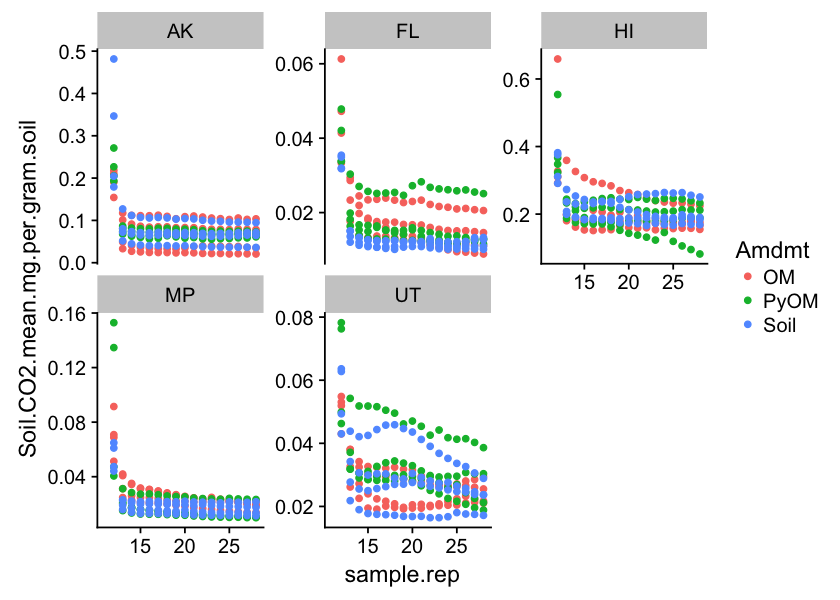

In [33]:
options(repr.plot.width=7, repr.plot.height=5)
# Should be able to plot CO2 at each timestep

df = short.data%>%
    filter(Soil_Sample !="Blank")

p = ggplot(df,aes(x=sample.rep,y=Soil.CO2.mean.mg.per.gram.soil, colour=Amdmt))
p = p + geom_point()
p = p + facet_wrap(~Soil_Trtmt, scales="free_y",ncol=3)
#p = p + ylim(0,1000)
p

In [34]:
short.data = short.data[short.data$sample.rep != 11,]

In [35]:
short.data[, Soil.CO2.mean.mg.per.gram.soil.cum := as.numeric(NA)]
short.data[!is.na(Soil.CO2.mean.mg.per.gram.soil), Soil.CO2.mean.mg.per.gram.soil.cum := cumsum(Soil.CO2.mean.mg.per.gram.soil), by=(sample.test)]
#short.data[,Proportion_remaining_SoilC:= SoilC/(soil_carbon-SoilC.cum)]
short.data[, Amdmt.CO2.mean.mg.per.mg.amdmt.cum := as.numeric(NA)]
short.data[!is.na(Amdmt.CO2.mean.mg.per.mg.amdmt), Amdmt.CO2.mean.mg.per.mg.amdmt.cum := cumsum(Amdmt.CO2.mean.mg.per.mg.amdmt), by=(sample.test)]

short.data[, Soil.CO2.paired.mean.mg.per.gram.soil.cum := as.numeric(NA)]
short.data[!is.na(Soil.CO2.paired.mean.mg.per.gram.soil), Soil.CO2.paired.mean.mg.per.gram.soil.cum := cumsum(Soil.CO2.paired.mean.mg.per.gram.soil), by=(sample.test)]
short.data[, Amdmt.CO2.paired.mean.mg.per.mg.amdmt.cum := as.numeric(NA)]
short.data[!is.na(Amdmt.CO2.paired.mean.mg.per.mg.amdmt), Amdmt.CO2.paired.mean.mg.per.mg.amdmt.cum := cumsum(Amdmt.CO2.paired.mean.mg.per.mg.amdmt), by=(sample.test)]

short.data[, Soil.CO2.mg.per.gram.soil.cum := as.numeric(NA)]
short.data[!is.na(Soil.CO2.mg.per.gram.soil), Soil.CO2.mg.per.gram.soil.cum := cumsum(Soil.CO2.mg.per.gram.soil), by=(sample.test)]
short.data[, Amdmt.CO2.mg.per.mg.amdmt.cum := as.numeric(NA)]
short.data[!is.na(Amdmt.CO2.mg.per.mg.amdmt), Amdmt.CO2.mg.per.mg.amdmt.cum := cumsum(Amdmt.CO2.mg.per.mg.amdmt), by=(sample.test)]

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

sample.test samprep     sample.rep FRAC_DAYS_SINCE_JAN1 CO2tot    
1     4          00004,00012 12         249.7838              741.3061 
2     7          00007,00012 12         249.8277              747.7710 
3    10          00010,00012 12         249.8717              681.3038 
4    61          00061,00012 12         250.6200              562.5411 
5     5          00005,00012 12         249.7984              473.4184 
6     8          00008,00012 12         249.8423              548.4243 
7    11          00011,00012 12         249.8863              623.1565 
8    62          00062,00012 12         250.6348              464.7762 
9     3          00003,00012 12         249.7690             1197.6613 
10    6          00006,00012 12         249.8131              434.3929 
11    9          00009,00012 12         249.8571              832.7290 
12   12          00012,00012 12         249.9009              486.8767 
13    4          00004,00013 13         250.7201              397.0766 
14    7          00007,00013 13         250.7640              481.9819 
15   10          00010,00013 13         250.8080              370.3032 
16   61          00061,00013 13         251.5566              184.9552 
17    5          00005,00013 13         250.7353              171.2860 
18    8          00008,00013 13         250.7788              218.8417 
19   11          00011,00013 13         250.8228              195.2711 
20   62          00062,00013 13         251.5712              177.4572 
21    3          00003,00013 13         250.7055              149.4080 
22    6          00006,00013 13         250.7495              181.5992 
23    9          00009,00013 13         250.7935              317.5993 
24   12          00012,00013 13         250.8374              199.2229 
25    4          00004,00014 14         251.6565              301.8268 
26    7          00007,00014 14         251.7004              443.5133 
27   10          00010,00014 14         251.7444              323.6687 
28   61          00061,00014 14         252.4930              156.6854 
29    5          00005,00014 14         251.6713              155.1075 
30    8          00008,00014 14         251.7152              203.9908 
⋮    ⋮           ⋮           ⋮          ⋮                    ⋮         
1057 45          00045,00027 27         264.4320              200.41725
1058 48          00048,00027 27         264.4759              278.37640
1059 37          00037,00028 28         265.2497              956.42979
1060 40          00040,00028 28         265.2953              608.04439
1061 43          00043,00028 28         265.3392              746.53126
1062 46          00046,00028 28         265.3819              957.01343
1063 38          00038,00028 28         265.2644              259.03260
1064 41          00041,00028 28         265.3099              233.55107
1065 44          00044,00028 28         265.3537              361.28190
1066 47          00047,00028 28         265.3977              448.50577
1067 39          00039,00028 28         265.2791              268.39365
1068 42          00042,00028 28         265.3245              326.34881
1069 45          00045,00028 28         265.3683              196.66708
1070 48          00048,00028 28         265.4123              267.82820
1071 64          00064,00012 12         250.6630             1230.15917
1072 64          00064,00014 14         252.5359               83.79628
1073 64          00064,00015 15         253.4724               79.73328
1074 64          00064,00016 16         254.4085               79.56085
1075 64          00064,00017 17         255.3449               79.12500
1076 64          00064,00018 18         256.2814               77.88445
1077 64          00064,00019 19         257.2177               78.94333
1078 64          00064,00020 20         258.1546               79.60766
1079 64          00064,00021 21         259.0906               76.30619
1080 64          00064,00022 22         260.0

Warning message:
“Removed 340 rows containing missing values (geom_point).”

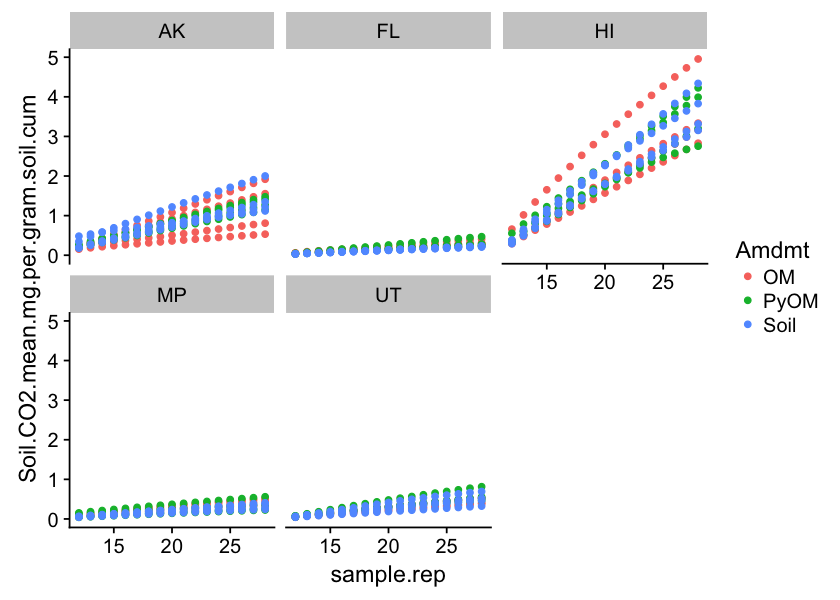

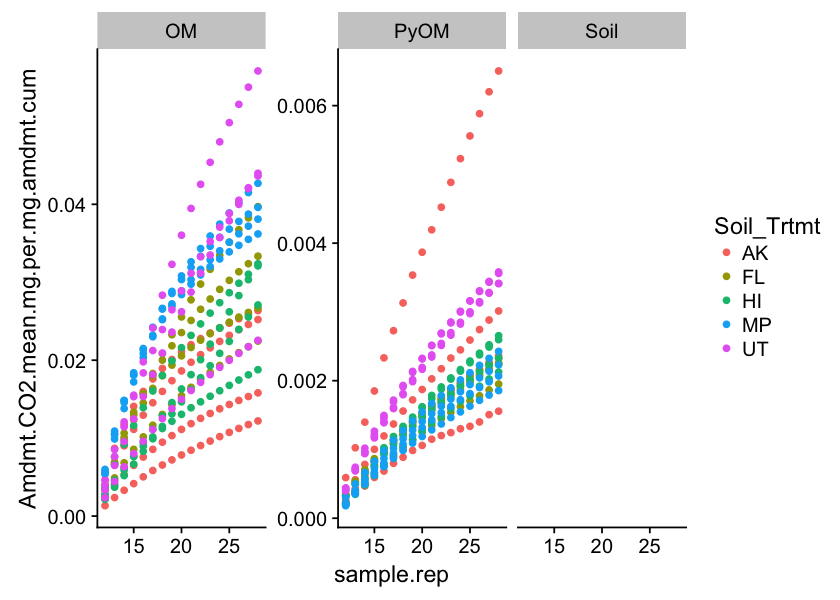

In [36]:
options(repr.plot.width=7, repr.plot.height=5)
# Should be able to plot CO2 at each timestep

df = short.data%>%
    filter(Soil_Sample !="Blank")

p = ggplot(df,aes(x=sample.rep,y=Soil.CO2.mean.mg.per.gram.soil.cum, colour=Amdmt))
p = p + geom_point()
p = p + facet_wrap(~Soil_Trtmt, ncol=3)
#p = p + ylim(0,1000)
p

p = ggplot(df,aes(x=sample.rep,y=Amdmt.CO2.mean.mg.per.mg.amdmt.cum, colour=Soil_Trtmt))
p = p + geom_point()
p = p + facet_wrap(~Amdmt, scales="free_y", ncol=3)
#p = p + ylim(0,1000)
p

In [38]:
levels(as.factor(short.data$sample.rep))

[1] "12" "13" "14" "15" "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"
[16] "27" "28"

In [39]:
# Save this data
saveRDS(short.data,"../data/Picarro_data/short.data.12-28.rds")